## How to predict stream using a trained model

#Here we show how to predict continous waveform using a trained u-net model (unet.ckpt-590000)

# load modules

In [1]:
from __future__ import print_function

import os
from obspy import UTCDateTime
os.environ['KMP_DUPLICATE_LIB_OK']='True'

from data_io import load_stream
import numpy as np
import tensorflow as tf
import time
import unet

/usr/local/anaconda3/envs/eirs/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:523: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/usr/local/anaconda3/envs/eirs/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:524: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/usr/local/anaconda3/envs/eirs/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:525: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/usr/local/anaconda3/envs/eirs/lib/python3.6/site-packages

# Subroutine 

In [2]:
def preprocess_stream(stream):
    stream = stream.detrend('constant')
    ##add by mingzhao,2017/12/2
    stream =stream.filter('bandpass', freqmin=0.5, freqmax=20)
    ##########
    return stream

def fetch_window_data(stream,j):
    """fetch data from a stream window and dump in np array"""
    data = np.empty((3001, j))
    for i in range(j):
        data[:, i] = stream[i].data.astype(np.float32)
    data = np.expand_dims(data, 0)
    return data

def group_consecutives(vals, step=1):
    """Return list of consecutive lists of numbers from vals (number list)."""
    run = []
    result = [run]
    expect = None
    for v in vals:
        if (v == expect) or (expect is None):
            run.append(v)
        else:
            run = [v]
            result.append(run)
        expect = v + step
    return result

# input parameters

In [3]:
n_events = 0
time_start = time.time()
stream_path =""
checkpoint_path ="unet.ckpt-590000"
batch_size=1 
output_dir="output/predict_from_stream"
window_size=30
window_step=31
image_size=3001
stream_file="./PWU20080720223000.mseed"

# the continuous waveform

 + Preprocess stream 3 Trace(s) in Stream:
XX.PWU..BHE | 2008-07-20T22:30:00.000000Z - 2008-07-20T22:32:00.000000Z | 100.0 Hz, 12001 samples
XX.PWU..BHN | 2008-07-20T22:30:00.000000Z - 2008-07-20T22:32:00.000000Z | 100.0 Hz, 12001 samples
XX.PWU..BHZ | 2008-07-20T22:30:00.000000Z - 2008-07-20T22:32:00.000000Z | 100.0 Hz, 12001 samples
 -- Stream is ready, starting detection


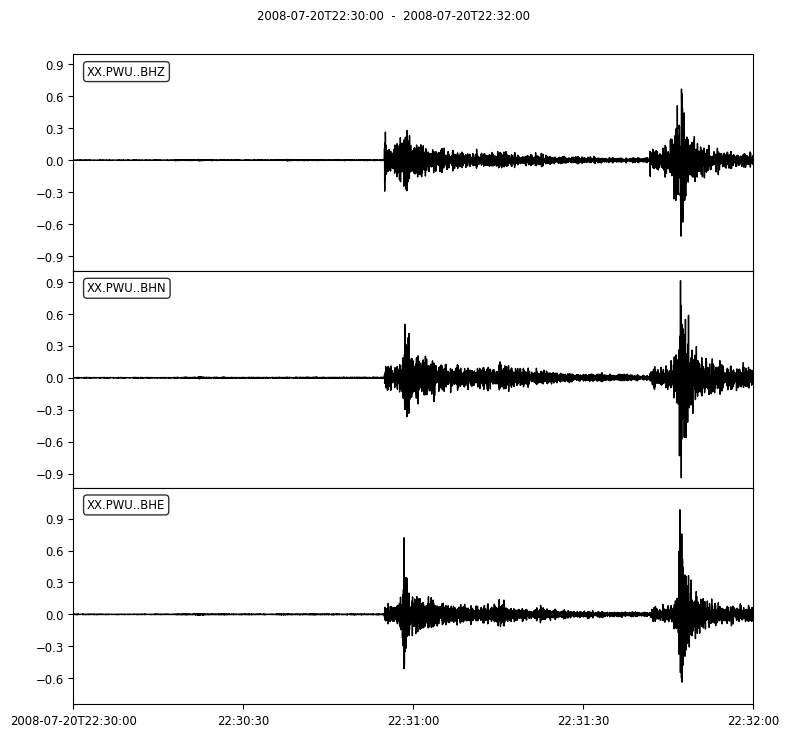

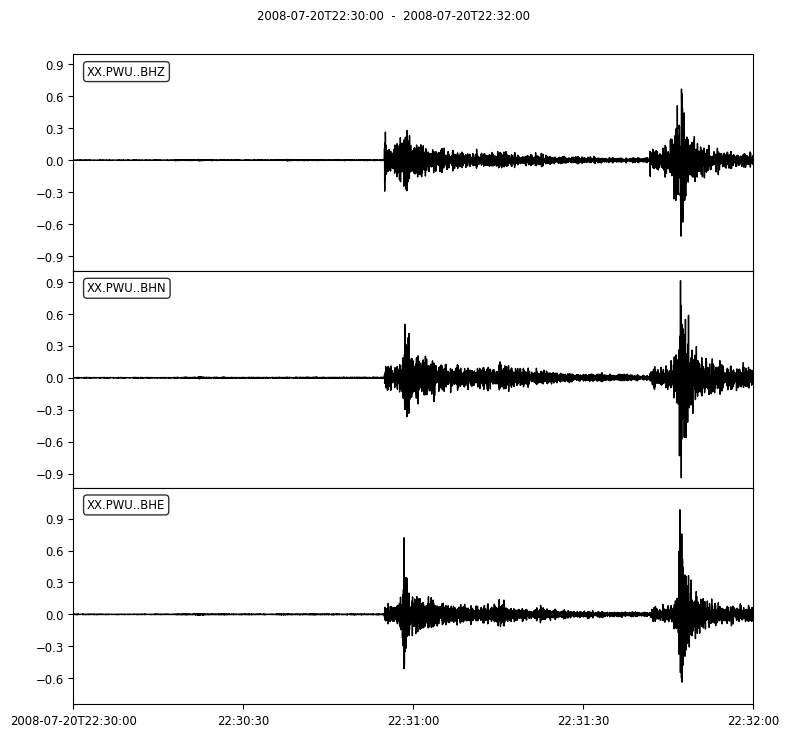

In [4]:
stream = load_stream(stream_file)
stream = stream.normalize()

print (" + Preprocess stream {}".format(stream))
stream = preprocess_stream(stream)
print (" -- Stream is ready, starting detection")
stream.plot()

# the predict process using unet (with tensorflow)

input_shape,output_shape Tensor("upsample6/Shape:0", shape=(3,), dtype=int32) Tensor("upsample6/stack:0", shape=(3,), dtype=int32)
num_filters_in, output_shape,weights 128 Tensor("upsample6/stack:0", shape=(3,), dtype=int32) <tf.Variable 'upsample6/weights:0' shape=(8, 128, 128) dtype=float32_ref>
input_shape,output_shape Tensor("upsample7/Shape:0", shape=(3,), dtype=int32) Tensor("upsample7/stack:0", shape=(3,), dtype=int32)
num_filters_in, output_shape,weights 128 Tensor("upsample7/stack:0", shape=(3,), dtype=int32) <tf.Variable 'upsample7/weights:0' shape=(8, 128, 128) dtype=float32_ref>
input_shape,output_shape Tensor("upsample8/Shape:0", shape=(3,), dtype=int32) Tensor("upsample8/stack:0", shape=(3,), dtype=int32)
num_filters_in, output_shape,weights 64 Tensor("upsample8/stack:0", shape=(3,), dtype=int32) <tf.Variable 'upsample8/weights:0' shape=(8, 64, 64) dtype=float32_ref>
input_shape,output_shape Tensor("upsample9/Shape:0", shape=(3,), dtype=int32) Tensor("upsample9/stack:0", 

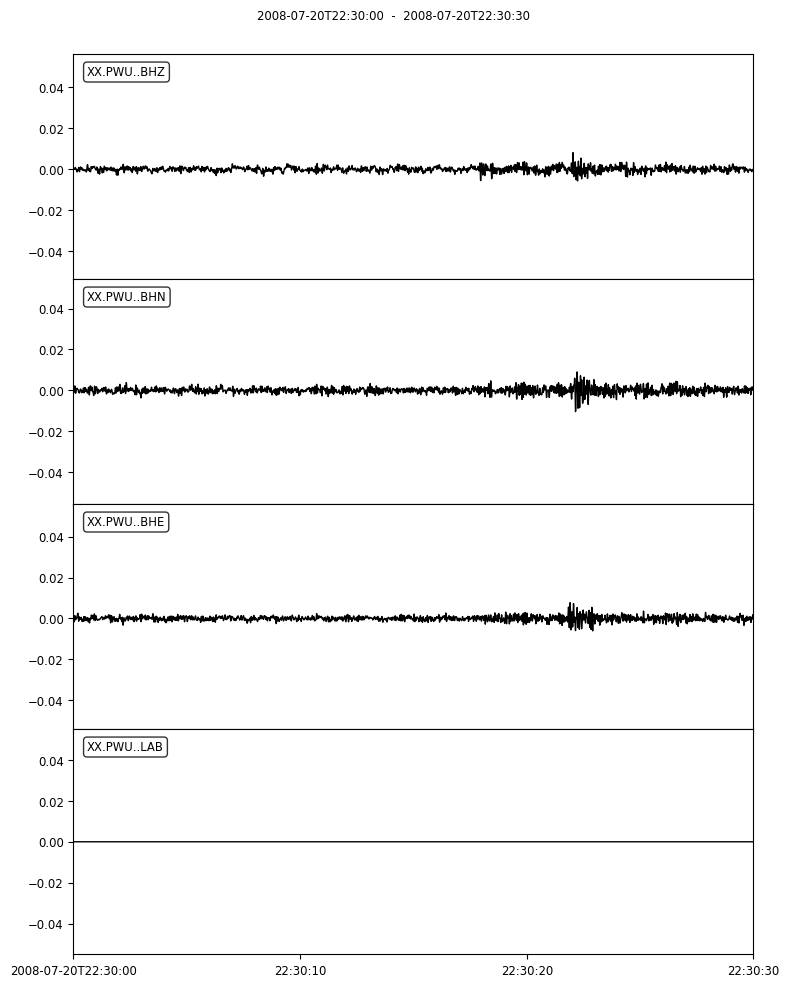

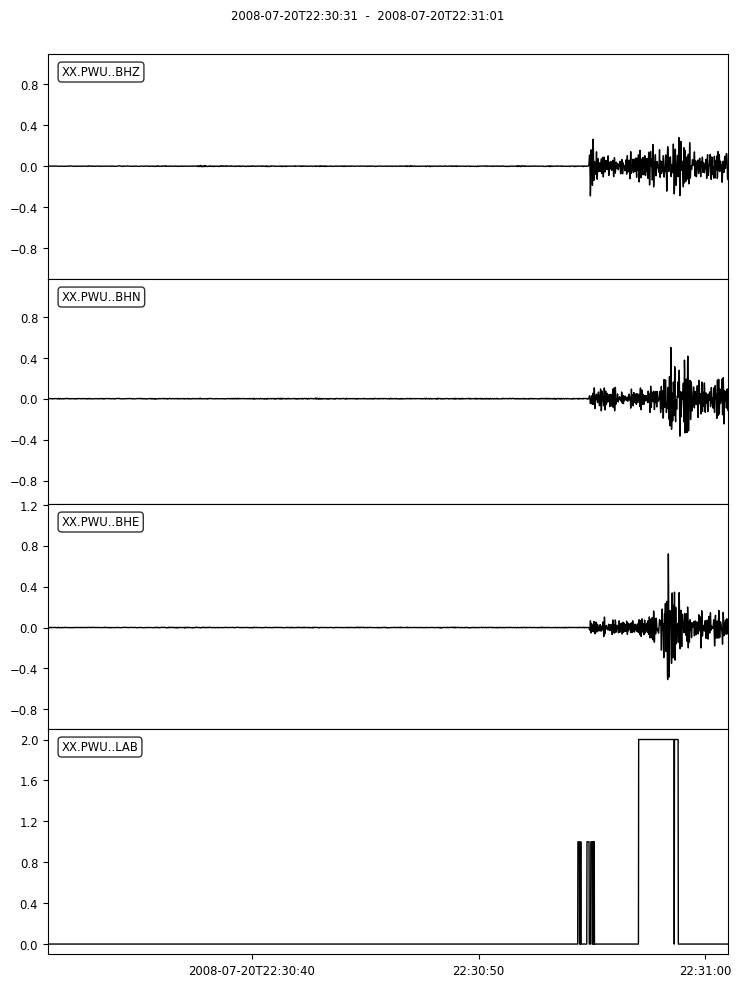

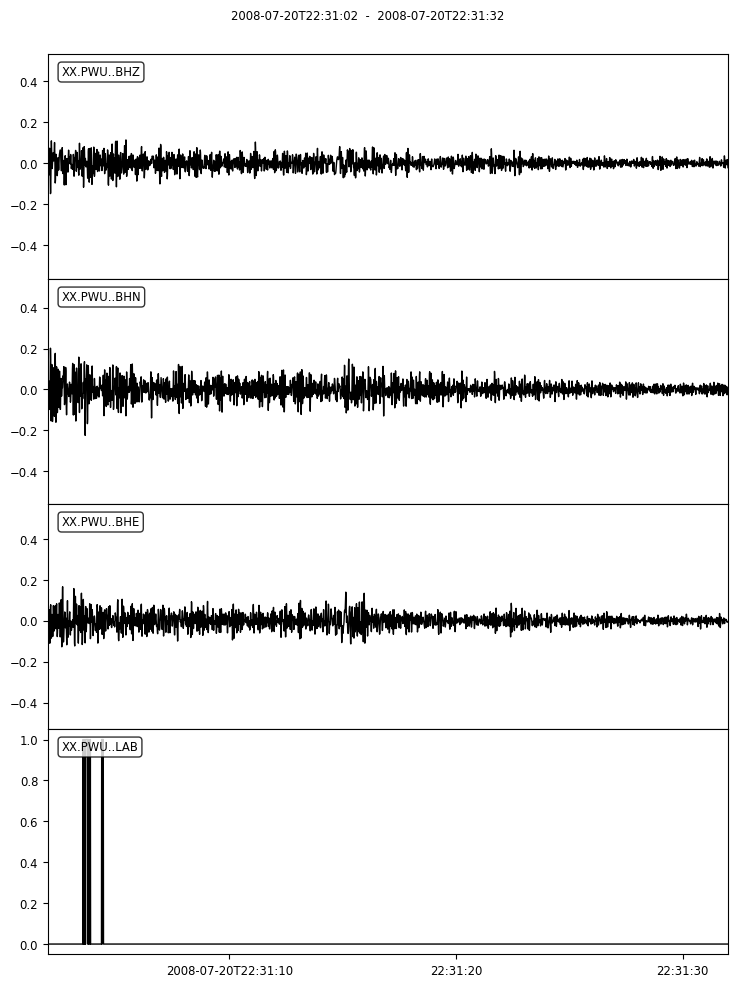

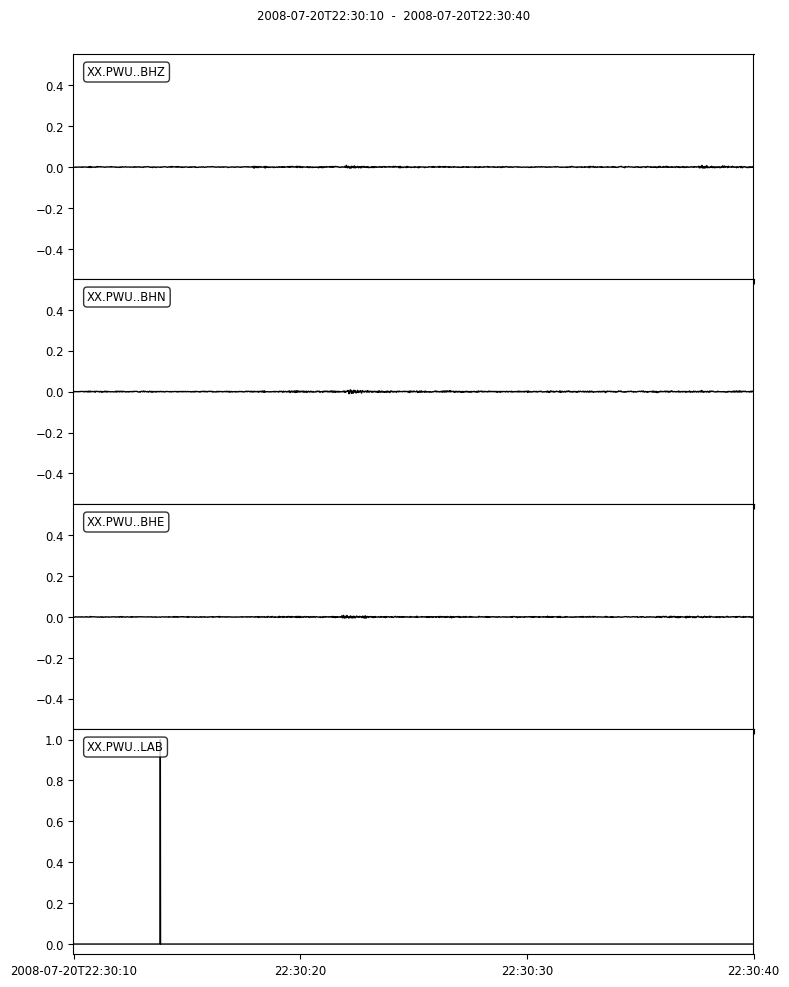

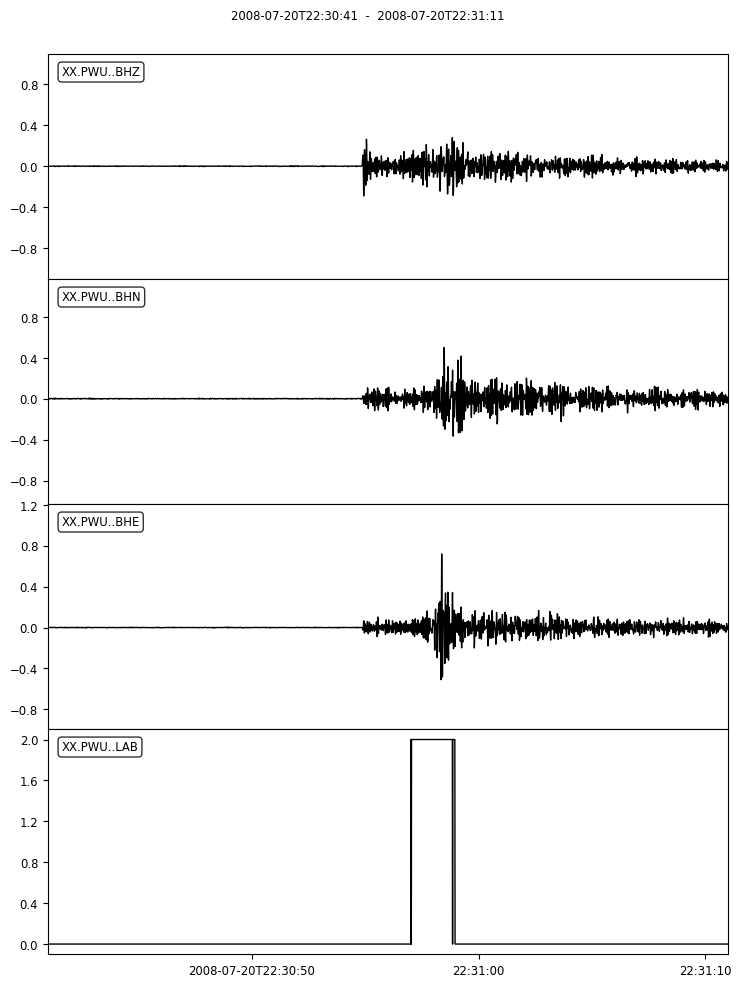

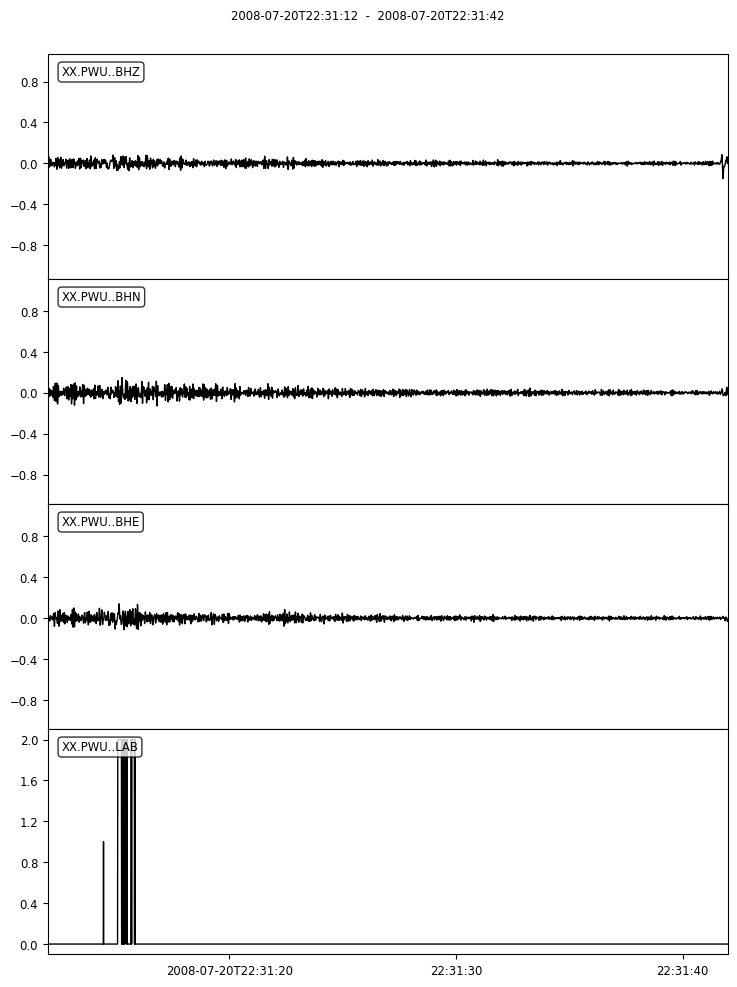

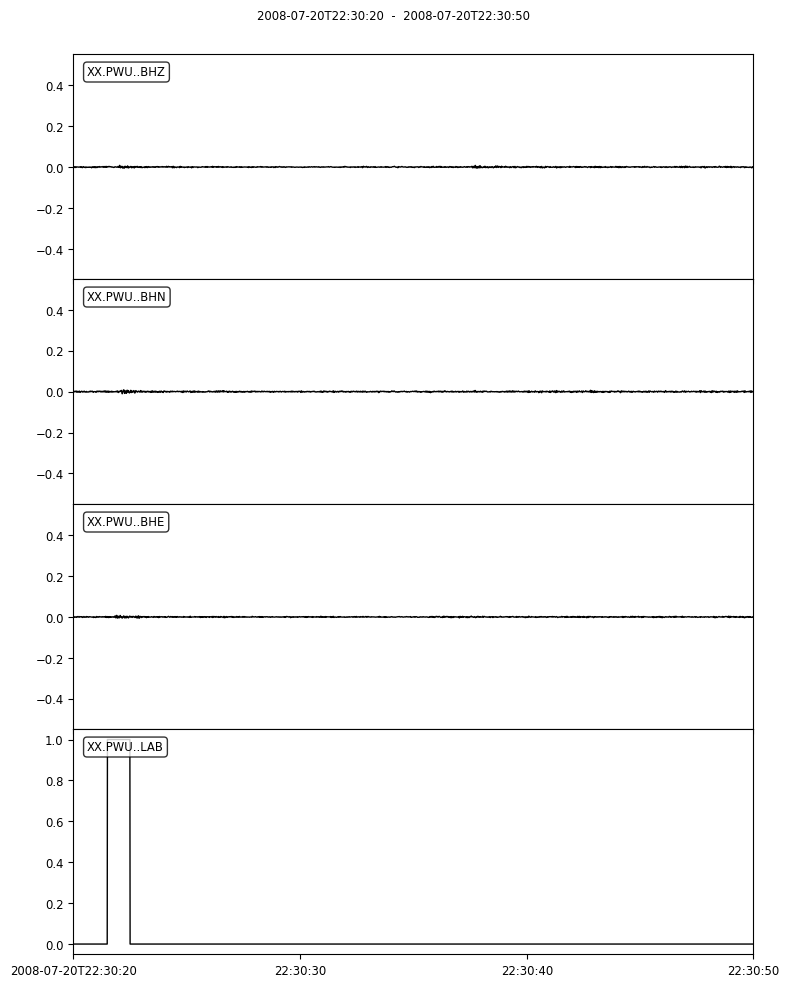

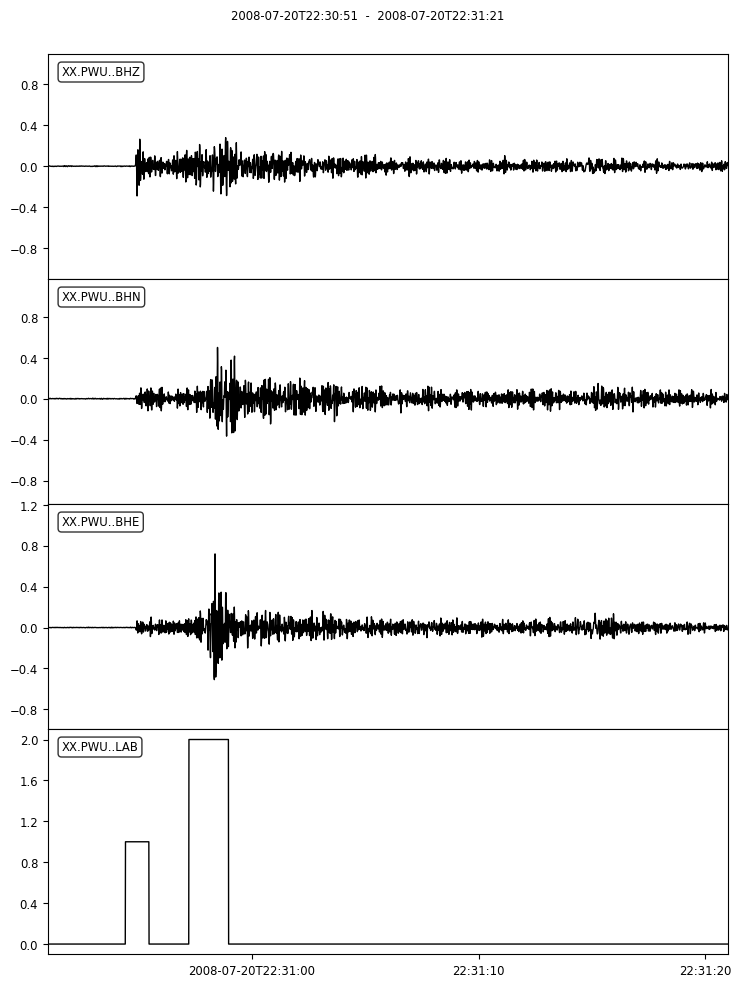

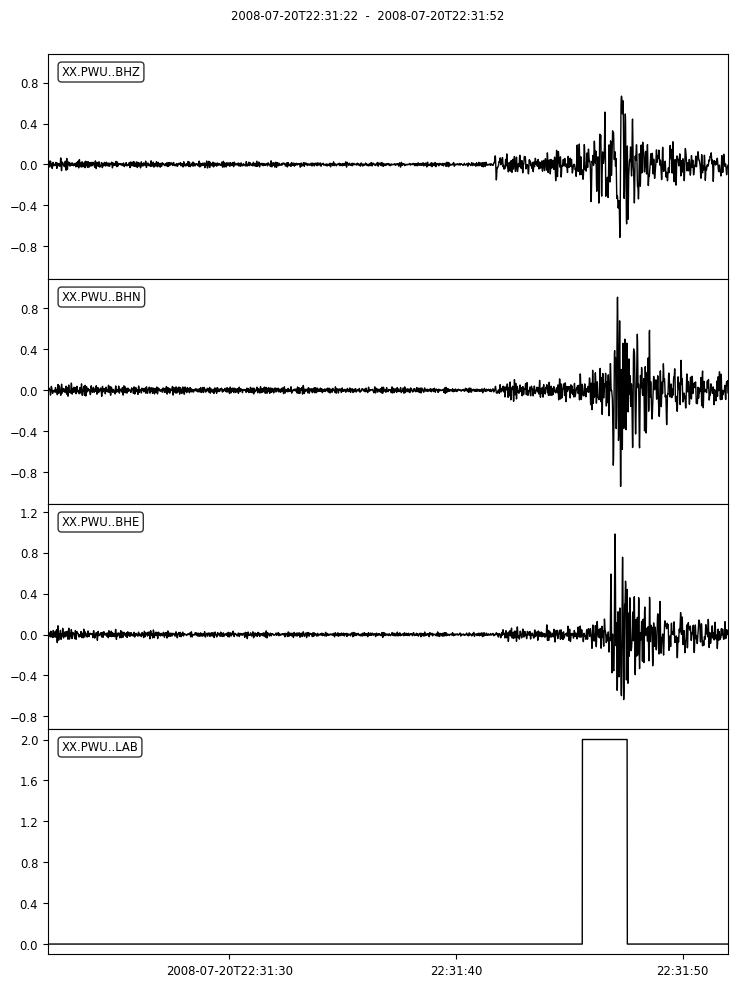

In [5]:
samples = {
        'data': tf.placeholder(tf.float32,
                                   shape=(batch_size, image_size, 3),
                                   name='input_data')}
events_dic = {"slice_start_time": [],
                  "P_pick": [],
                  "stname": [],
                  "utc_timestamp_p": [],
                  "utc_timestamp_s": [],
                  "S_pick": []}
p_timestamp = 0
with tf.Session() as sess:
    logits = unet.build_30s(samples['data'], 3, False)
    
    init_op = tf.group(tf.global_variables_initializer(), tf.local_variables_initializer())

    sess.run(init_op)
    saver = tf.train.Saver()

    if not tf.gfile.Exists(checkpoint_path + '.meta'):
        raise ValueError("Can't find checkpoint file")
    else:
        print('[INFO    ]\tFound checkpoint file, restoring model.')
        saver.restore(sess, checkpoint_path)
    coord = tf.train.Coordinator()

    threads = tf.train.start_queue_runners(sess=sess, coord=coord)

    lists = np.arange(0,30,10)
    for i in lists:
        win_gen = stream.slide(window_length=window_size, step=window_step,offset=i,
                                                                                 include_partial_windows=False)
        for idx, win in enumerate(win_gen):
            predicted_images = unet.predict(logits, batch_size, image_size)
            to_fetch = [predicted_images,samples['data']]

            feed_dict = {samples['data']: fetch_window_data(win.copy().normalize(),3)}
   
            predicted_images_value, images_value = sess.run(to_fetch,feed_dict)

            clusters_p = np.where(predicted_images_value[0, :] == 1)
            clusters_s = np.where(predicted_images_value[0, :] == 2)
            p_boxes = group_consecutives(clusters_p[0])
            s_boxes = group_consecutives(clusters_s[0])
            tp = []
            ts = []
            tpstamp = []
            tsstamp = []

            if len(p_boxes) > 1:
                for ip in range(len(p_boxes)):
                    print (len(p_boxes),p_boxes,p_boxes[ip])
                    tpmean = float(min(p_boxes[ip]) / 200.00 + max(p_boxes[ip]) / 200.00)
                    tp.append(tpmean)
                    tpstamp = UTCDateTime(win[0].stats.starttime + tpmean).timestamp
                    print("-----------")
                    print(UTCDateTime(tpstamp))
            if len(p_boxes) > 1 or len(s_boxes) > 1:
                events_dic["slice_start_time"].append(win[0].stats.starttime)
                events_dic["stname"].append(win[0].stats.station)
                events_dic["P_pick"].append(tp)
                events_dic["S_pick"].append(ts)
                events_dic["utc_timestamp_p"].append(tpstamp)
                events_dic["utc_timestamp_s"].append(tsstamp)
                print(events_dic)

            win_filtered = win.copy()
            lab = win_filtered[2].copy()
            lab.stats.channel = "LAB"
            # lab =win[0].copy()

            print("predicted_images_value", predicted_images_value.shape)
            lab.data[...] = predicted_images_value[0, :]
            win_filtered += lab
            # win_filtered[-2:].plot()
            win_filtered.plot()
            # Wait for threads to finish.
            coord.join(threads)

## stream data to kafka

In [36]:
from kafka import KafkaProducer
import json


def sendMsg(topic, msg_dict):
    producer = KafkaProducer(bootstrap_servers="8.131.255.216:9092",
                             value_serializer=lambda v: json.dumps(v).encode('utf-8'))
    '''send json  String to kafka  '''
    producer.send(topic, msg_dict)
    producer.close()

In [37]:
from  obspy import read
from collections import defaultdict
st = read("PWU20080720223000.mseed")
dic = defaultdict(dict)
for tr in st:
    tr_id = tr.get_id()
    dic[tr_id]['stats'] = json.dumps(tr.stats, default=lambda obj: obj.__dict__)
    dic[tr_id]['data'] = tr.data.tolist()
    print(tr.stats)

         network: XX
         station: PWU
        location: 
         channel: BHZ
       starttime: 2008-07-20T22:30:00.000000Z
         endtime: 2008-07-20T22:32:00.000000Z
   sampling_rate: 100.0
           delta: 0.01
            npts: 12001
           calib: 1.0
         _format: MSEED
           mseed: AttribDict({'dataquality': 'D', 'number_of_records': 24, 'encoding': 'FLOAT64', 'byteorder': '>', 'record_length': 4096, 'filesize': 294912})
         network: XX
         station: PWU
        location: 
         channel: BHE
       starttime: 2008-07-20T22:30:00.000000Z
         endtime: 2008-07-20T22:32:00.000000Z
   sampling_rate: 100.0
           delta: 0.01
            npts: 12001
           calib: 1.0
         _format: MSEED
           mseed: AttribDict({'dataquality': 'D', 'number_of_records': 24, 'encoding': 'FLOAT64', 'byteorder': '>', 'record_length': 4096, 'filesize': 294912})
         network: XX
         station: PWU
        location: 
         channel: BHN
       sta

In [67]:
sendMsg("pwave_test", dic)

## get p-wave config from MySQL

In [38]:
import pymysql

db = pymysql.connect(host="rm-2ze78q57mdh214rk0125010hm.mysql.rds.aliyuncs.com",
                     user="seis",
                     password="Neu@2021",
                     database="eirs")
cursor = db.cursor()
cursor.execute("select pwave_before, pwave_after from config")
data = list(cursor.fetchone())
print(data)
pwave_before = data[0]
pwave_after = data[1]
db.close()

[9, 160]


## cut stream (p-wave before & after n seconds)

In [43]:
dt = UTCDateTime(1216593054.91)
stream_cut = st.slice(dt, dt + 0.5)
for tr in stream_cut:
    print(tr.stats)

         network: XX
         station: PWU
        location: 
         channel: BHZ
       starttime: 2008-07-20T22:30:54.910000Z
         endtime: 2008-07-20T22:30:55.410000Z
   sampling_rate: 100.0
           delta: 0.01
            npts: 51
           calib: 1.0
         _format: MSEED
           mseed: AttribDict({'dataquality': 'D', 'number_of_records': 24, 'encoding': 'FLOAT64', 'byteorder': '>', 'record_length': 4096, 'filesize': 294912})
      processing: ['ObsPy 1.2.2: trim(endtime=UTCDateTime(2008, 7, 20, 22, 30, 55, 410000)::fill_value=None::nearest_sample=True::pad=False::starttime=UTCDateTime(2008, 7, 20, 22, 30, 54, 910000))']
         network: XX
         station: PWU
        location: 
         channel: BHE
       starttime: 2008-07-20T22:30:54.910000Z
         endtime: 2008-07-20T22:30:55.410000Z
   sampling_rate: 100.0
           delta: 0.01
            npts: 51
           calib: 1.0
         _format: MSEED
           mseed: AttribDict({'dataquality': 'D', 'number_of_

## save cut stream to mini seed file

In [65]:
output_mseed_dir = "/Users/cui/Desktop"
output_label = "{}_{}.mseed".format(stream_cut[0].stats.station,
                                    UTCDateTime(stream_cut[0].stats.starttime).strftime("%Y%m%d%H%M%S"))
output_mseed = os.path.join(output_mseed_dir, output_label)
stream_cut.write(output_mseed, format="MSEED")